The following code is almost entierly from adityzjin's kernel (https://www.kaggle.com/adityajn105/getting-started-with-vggface-0-787-lb)
The only addition are annotations or vizualisation steps helping understanding each step for beginners. Being a junior myself, I had to check the documentation numerous times. So please excuse my potential mistakes and don't hesitate to tell me if you spot one.

In [3]:
#Importing the Keras implementation of the VGGface pre-trained model of face recognition
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-l1f4og9j
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-l1f4og9j
  Stored in directory: /tmp/pip-ephem-wheel-cache-27ro44uv/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [4]:
import gc
import cv2
import glob
from keras_vggface.utils import preprocess_input

def read_img(path):
    """
    Function:
    ---------
    Turns an image into an array
    
    Input:
    ------
    path = path of the image file
    
    Returns:
    --------
    An array containing floats
    """
    
    img = cv2.imread(path)
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

Using TensorFlow backend.


In [5]:
from collections import defaultdict
#Oppositely to a 'normal' dic() function, defaultdict doesn't return an error when trying to access an item with a key that hasn't been attributed, it creates a new item/key if it doesn't exit yet

allPhotos = defaultdict(list)
#First we iterate through all the directories in the train dataset, containing directories of people from the same family 
#Note: glob.glob work exclusively with unix, use "os" package instead if you are using another os
for family in glob.glob("data/recognizing-faces-in-the-wild/train/*"):
    #Then we iterate through the families directories to get the directory of each member
    for mem in glob.glob(family+'/*'):
        #Finally, we iterat through every photo in each member directory
        for photo in glob.glob(mem+'/*'):
            #Then we put all photos as items with their directory name (which here matches with each person id) as index
            allPhotos[mem].append(photo)

#Making a list with all ids
ppl = list(allPhotos.keys())
len(ppl)

2316

In [6]:
import pandas as pd
data = pd.read_csv('data/recognizing-faces-in-the-wild/train_relationships.csv')
data.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


In [7]:
#As you can see, the train-relationships document gives the actual kinship of each individual, but only by their family and
#member directory. The point here will be to turn them into full path for each person
data.p1 = data.p1.apply(lambda x: 'data/recognizing-faces-in-the-wild/train/'+x)
data.p2 = data.p2.apply(lambda x: 'data/recognizing-faces-in-the-wild/train/'+x)
data.head()

,p1,p2
0,data/recognizing-faces-in-the-wild/train/F0002...,data/recognizing-faces-in-the-wild/train/F0002...
1,data/recognizing-faces-in-the-wild/train/F0002...,data/recognizing-faces-in-the-wild/train/F0002...
2,data/recognizing-faces-in-the-wild/train/F0005...,data/recognizing-faces-in-the-wild/train/F0005...
3,data/recognizing-faces-in-the-wild/train/F0005...,data/recognizing-faces-in-the-wild/train/F0005...
4,data/recognizing-faces-in-the-wild/train/F0009...,data/recognizing-faces-in-the-wild/train/F0009...


In [8]:
data.shape

(3598, 2)

In [9]:
#Here we have 3598, 2 lines, each one with kinship matching. Still, we will check if every person depicted
#in the dataframe actually matches the ones we have in our data

data = data[((data.p1.isin(ppl)) & (data.p2.isin(ppl)))]
data = [(x[0], x[1]) for x in data.values]
len(data)

3362

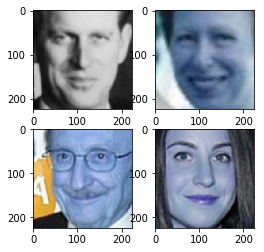

In [36]:
#Far from useless: 236 lines referred to at least one person we didn't have in our train data!
#Now we will vizualise some random photos

%matplotlib inline
import matplotlib.pyplot as plt
from random import choice, sample

#We will go for 2 pairs of images but feel free to show as much as you want
f, ax = plt.subplots(2, 2, figsize=(4, 4))
#This one is a bit tricky. If you don't understand right away, further explanation follows in the few next cells
batch = sample(data, 2)
for i, j in [(0,0), (0,1), (1,0), (1,1)]:
    #The iteration associate i with the first number from each tuple (so here 0, 0, 1, 1) and j the second (0, 1, 0, 1)
    #It allows to iterate through all the indeces possibilities in batch (which is a list of two tuples with two images)
    #Therefore, we iterate to associate each subplot to one image randomly chosen in the directory associated with the member
    #id contained in the two lines from batch
    ax[i][j].imshow(cv2.imread(choice(allPhotos[batch[i][j]])))

In [37]:
#As each line from the data dataframe contains a pair, getting a random line will get 2 images
print(batch)

[('data/recognizing-faces-in-the-wild/train/F0601/MID1', 'data/recognizing-faces-in-the-wild/train/F0601/MID8'), ('data/recognizing-faces-in-the-wild/train/F0881/MID6', 'data/recognizing-faces-in-the-wild/train/F0881/MID2')]


In [38]:
#f matches with the figure object, ax with the axes
print(f)
print(ax)

Figure(288x288)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dad9a2208>


In [39]:
#All objects from this iteration are integers
for i, j in [(0,0), (0,1), (1,0), (1,1)]:
    print(type(i))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [41]:
#The following line allows to go through a specific family member directory through index contained in a line from batch
allPhotos[batch[1][1]]

['data/recognizing-faces-in-the-wild/train/F0881/MID2/P09299_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0881/MID2/P09302_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0881/MID2/P09303_face2.jpg',
 'data/recognizing-faces-in-the-wild/train/F0881/MID2/P09298_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0881/MID2/P09295_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0881/MID2/P09296_face3.jpg']

In [42]:
#Building a validation set. As we cannot mix up members from different families together, we can't use the good ol'
#train_test_split

train = [x for x in data if 'F09' not in x[0]]
val = [x for x in data if 'F09' in x[0]]
len(train), len(val)

(3066, 296)

In [49]:
#This method allowed us to have a 90% train 10% validation which is acceptable

def getImages(p1, p2):
    """
    Function:
    ---------
    Get a random image from allPhotos 
    
    Input:
    ------
    p1 = first path for a family member directory
    p2 = second path for a family member directory
    
    Returns:
    --------
    A random image from p1 and another from p2 in the form of arrays
    
    """
    
    p1 = read_img(choice(allPhotos[p1]))
    p2 = read_img(choice(allPhotos[p2]))
    return p1, p2


In [63]:
import numpy as np

def getMiniBatch(batch_size=16, data=train):
    p1=[]; p2=[]; Y=[]
    #Gets some pairs from data (default = 8)
    batch=sample(data, batch_size//2)
    #Iterates through pairs
    for x in batch:
        #Assigns a variable where each one takes one of each pair in the form of lists of arrays
        _p1, _p2 = getImages(*x)
        #Append each array to p1 and p2
        #Adds 1 to the Y list for each appended array to p1 and p2
        p1.append(_p1); p2.append(_p2); Y.append(1)
    
    #As long as the lenght of Y doesn't equals the batch_size (which will happen when all the appendings will be over
    #as there are 4 pairs of batch_size //2)
    while len(Y) < batch_size:
        #Make _p1 and p2 equal to random family member id
        _p1, _p2 = tuple(np.random.choice(ppl, size=2, replace=False))
        #Adds a condition in case _p1 and _p2 aren't pairs
        if (_p1, _p2) not in train+val and (_p2, _p1) not in train+val:
            #Assign the value 
            _p1, _p2 = getImages(p1, p2)
            p1.append(_p1); p2.append(_p2); Y.append(0)
        return[np.array(p1), np.array(p2)], np.array(Y)

In [64]:
train

[('data/recognizing-faces-in-the-wild/train/F0002/MID1',
  'data/recognizing-faces-in-the-wild/train/F0002/MID3'),
 ('data/recognizing-faces-in-the-wild/train/F0002/MID2',
  'data/recognizing-faces-in-the-wild/train/F0002/MID3'),
 ('data/recognizing-faces-in-the-wild/train/F0005/MID1',
  'data/recognizing-faces-in-the-wild/train/F0005/MID2'),
 ('data/recognizing-faces-in-the-wild/train/F0005/MID3',
  'data/recognizing-faces-in-the-wild/train/F0005/MID2'),
 ('data/recognizing-faces-in-the-wild/train/F0009/MID1',
  'data/recognizing-faces-in-the-wild/train/F0009/MID4'),
 ('data/recognizing-faces-in-the-wild/train/F0009/MID1',
  'data/recognizing-faces-in-the-wild/train/F0009/MID3'),
 ('data/recognizing-faces-in-the-wild/train/F0009/MID1',
  'data/recognizing-faces-in-the-wild/train/F0009/MID2'),
 ('data/recognizing-faces-in-the-wild/train/F0009/MID1',
  'data/recognizing-faces-in-the-wild/train/F0009/MID6'),
 ('data/recognizing-faces-in-the-wild/train/F0009/MID2',
  'data/recognizing-fac